# Determining the value of cars

**Data description**

Features  


DateCrawled - date the questionnaire was downloaded from the database  
VehicleType - type of car body  
RegistrationYear - year of car registration  
Gearbox - gearbox type  
Power - power (hp)  
Model - car model  
Kilometer - mileage (km)  
RegistrationMonth - month of the car registration  
FuelType - fuel type  
Brand - car brand  
NotRepaired - if the car was repaired or not  
DateCreated - date of questionnaire creation  
NumberOfPictures - number of car pictures  
PostalCode - postal code of questionnaire owner (user)  
LastSeen - date of the last activity of the user  


Target feature  
Price - price (euro)  


## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from catboost import Pool, cv
from datetime import datetime 
import time

In [2]:
df = pd.read_csv('../../datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

The data contains 354369 rows and 16 columns. There are gaps in data. 

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Let us select from the sample the numerical and categorical attributes, which are further necessary for the training of models.

In [8]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']

In [9]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

Let's build histograms for numerical signs, for this we will write a function.

In [10]:
def hist_plot(list):
    for i in list:
        df.plot(y = i, kind = 'hist', bins = 100, figsize = (6,6))
        plt.ylabel('Frequency')
        plt.title(i)
        plt.xlabel(i)
        plt.show()

In [11]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [12]:
df_initial_length = len(df)

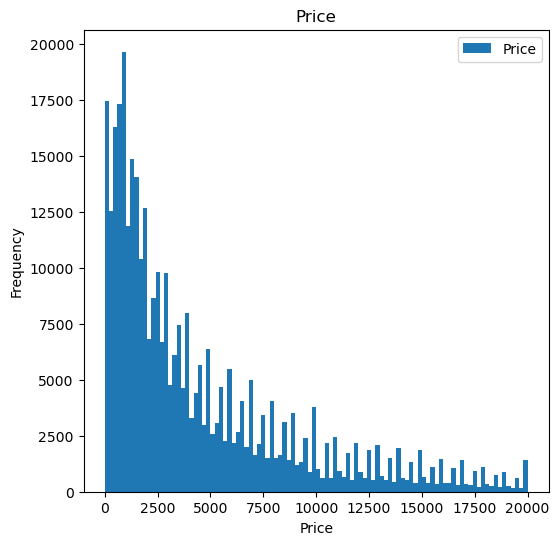

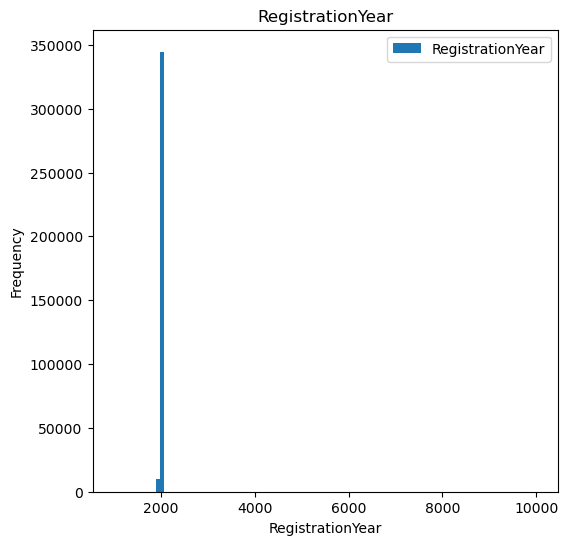

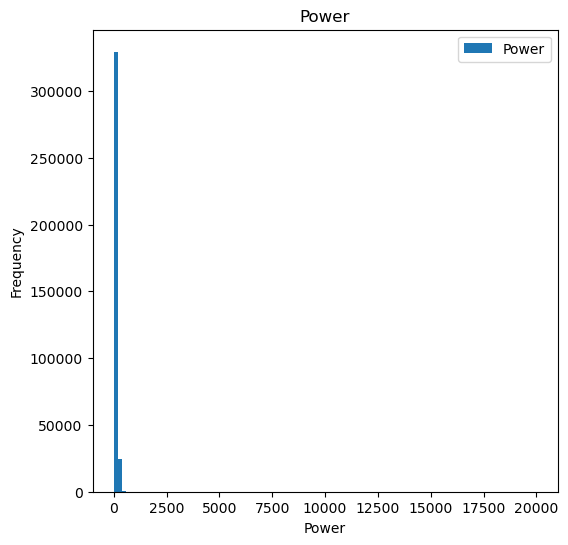

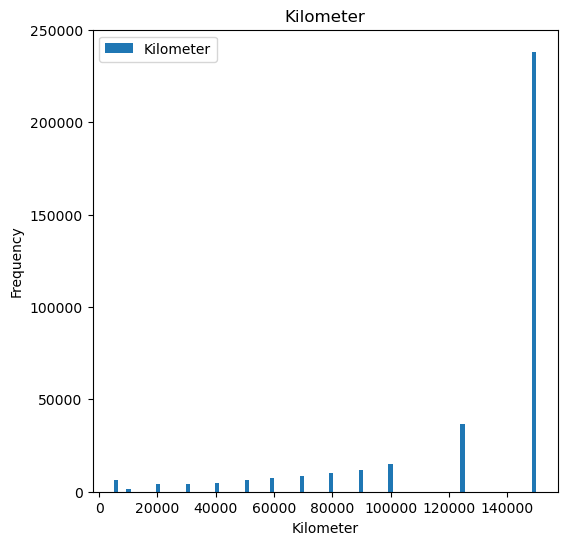

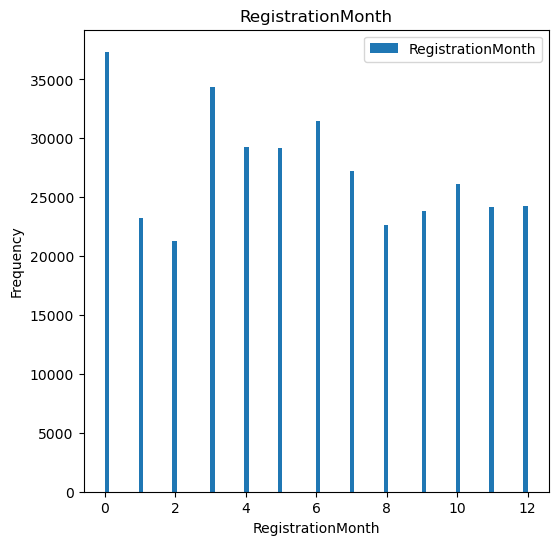

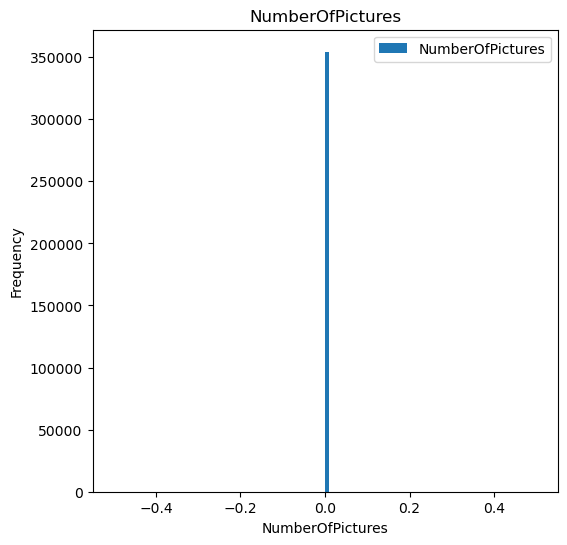

In [13]:
hist_plot(numeric)

Гистограммы показывают, что необходимо рассмотреть каждый признак в отдельности более подробно, так как есть пики в районе нуля в признаках `Price`, `Power`, а также не верно указан год регистрации автомобиля.

<AxesSubplot:>

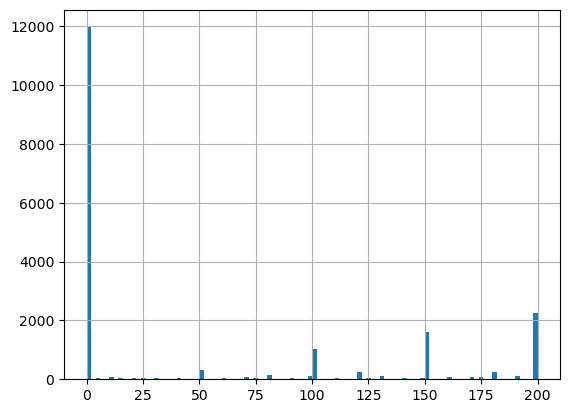

In [14]:
df['Price'].hist(range = (0,200), bins = 100)

В признеке `Price` на гистограмме виден пик при цене 0.

In [15]:
df['Price'][df['Price'] == 0].count()

10772

In [16]:
df['Price'][df['Price'] == 0].count()/df_initial_length

0.030397692800442477

The total number of objects in which the value of the car is zero is 3%. Delete lines where `Price` equals zero.

In [17]:
df = df[df['Price'] != 0]

In [18]:
df_initial_length - len(df)

10772

In [19]:
length2 = len(df)

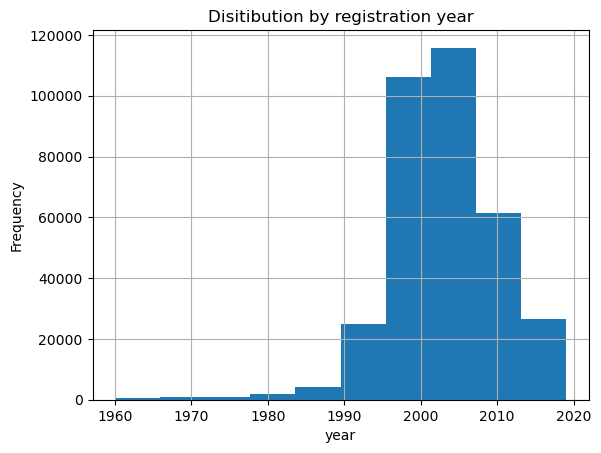

In [20]:
df['RegistrationYear'].hist(range = (1960,2019))
plt.ylabel('Frequency')
plt.title('Disitibution by registration year')
plt.xlabel('year')
plt.show()


Let's filter the data by the period of car registration from 1920 to 2019.

In [21]:
df['RegistrationYear'][df['RegistrationYear'] < 1960].count()

340

In [22]:
df[df['RegistrationYear'] < 1960].head(50)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
3333,2016-03-15 21:36:20,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN,2016-03-15 00:00:00,0,53498,2016-04-07 08:16:11
6977,2016-03-24 08:37:22,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-24 00:00:00,0,19374,2016-04-06 20:46:08
10183,2016-03-27 13:59:08,1250,NaN,1910,NaN,0,other,5000,0,NaN,audi,NaN,2016-03-27 00:00:00,0,18445,2016-04-07 10:45:31
12993,2016-03-07 14:38:00,11000,other,1955,manual,40,NaN,50000,1,petrol,sonstige_autos,no,2016-03-07 00:00:00,0,59556,2016-03-14 06:44:36
13177,2016-03-19 13:45:25,2300,sedan,1958,manual,45,NaN,80000,1,petrol,sonstige_autos,NaN,2016-03-19 00:00:00,0,9600,2016-03-30 05:47:21
14971,2016-03-30 11:57:50,1,sedan,1959,auto,325,NaN,10000,7,petrol,sonstige_autos,NaN,2016-03-30 00:00:00,0,45968,2016-04-01 06:16:37
15414,2016-03-30 23:38:13,18000,sedan,1956,manual,30,NaN,150000,0,petrol,volkswagen,NaN,2016-03-30 00:00:00,0,82205,2016-04-05 23:17:35


In [23]:
df['RegistrationYear'][df['RegistrationYear'] > 2019].count()

86

In [24]:
df[df['RegistrationYear'] > 2019].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
12946,2016-03-29 18:39:40,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,2016-03-29 00:00:00,0,74523,2016-04-06 04:16:14
15870,2016-04-02 11:55:48,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-02 00:00:00,0,33649,2016-04-06 09:46:13
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23 00:00:00,0,21769,2016-04-05 20:16:15
17346,2016-03-06 16:06:20,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-06 00:00:00,0,55262,2016-03-30 20:46:55
18259,2016-03-16 20:37:54,300,NaN,2200,NaN,0,twingo,5000,12,NaN,renault,NaN,2016-03-16 00:00:00,0,45307,2016-04-07 06:45:32


In [25]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

In [26]:
length2 - len(df[(df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2019)])



426

Exclude from the sample 426 lines that do not match the parameters

In [27]:
df = df[(df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2019)].copy()

In [28]:
length3 = len(df)

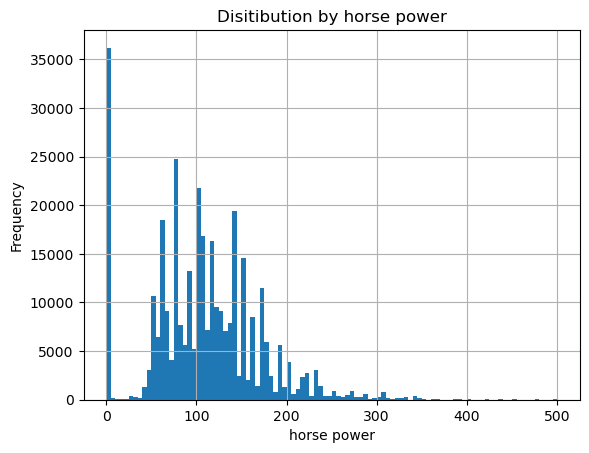

In [29]:
df['Power'].hist(range = (0,500), bins = 100)
plt.ylabel('Frequency')
plt.title('Disitibution by horse power')
plt.xlabel('horse power')
plt.show()

In [30]:
length3 - df['Power'][df['Power'] == 0].count()

307047

In [31]:
df['Power'][df['Power'] == 0].count()/length3

0.10526530505200031

There is a peak at zero values in the motor power data. Let's replace the zero values with NaN in order to later replace the missing values in this trait with the median (since the distribution is not normal).

In [32]:
df['Power'] = df['Power'].replace([0],np.nan)

In [33]:
df['Power']

0           NaN
1         190.0
2         163.0
3          75.0
4          69.0
          ...  
354363      NaN
354365      NaN
354366    101.0
354367    102.0
354368    100.0
Name: Power, Length: 343171, dtype: float64

We will not use the column `NumberOfPictures` since its values are always zero. The `PostalCode` and `RegistrationMonth` attributes will also not be used, since they do not greatly affect the cost of the car.

In [34]:
numeric_features = ['RegistrationYear', 'Power', 'Kilometer']

In [35]:
target_col = ['Price']

In [36]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [37]:
(df_initial_length - length3)/df_initial_length

0.03159982955619707

In [38]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          33571
RegistrationYear         0
Gearbox              17158
Power                36124
Model                17350
Kilometer                0
RegistrationMonth        0
FuelType             29286
Brand                    0
NotRepaired          65625
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [39]:
df.duplicated().sum()

4

In [40]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193.0,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83.0,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218.0,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131.0,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


There are duplicates in the data, let's remove them.

In [41]:
df = df.drop_duplicates()

In [42]:
df.duplicated().sum()

0

Replace the missing values in the categorical variables with "unknown"

In [43]:
df[categorical_features] = df[categorical_features].fillna('unknown')

In [44]:
(df_initial_length - len(df))/df_initial_length

0.03161111722526519

### Conclusion  
- We deleted 3% of all objects from the sample, whose price is equal to zero.
- The objects not falling in the range from 1920 to 2019 were removed according to the feature `RegistrationYear`.
- Zero values in the attribute `Power` were replaced with 'NaN'.
- Altogether a bit more than 3% of the objects have been removed from the dataset
- We will use the following numeric attributes for training the models: 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'
- Categorical attributes: 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode'
- Missing values in categorical variables replaced with "unknown"
- The missing values in the `Power` attribute are replaced by the median in the pipline.

## Model training

In [45]:
col = target_col + numeric_features + categorical_features
col

['Price',
 'RegistrationYear',
 'Power',
 'Kilometer',
 'VehicleType',
 'Gearbox',
 'Model',
 'FuelType',
 'Brand',
 'NotRepaired']

In [46]:
data = df[col].copy()

In [47]:
del df

In [48]:
test = data.sample(frac=0.2,random_state=42)
train_full = data[~data.index.isin(test.index)]

features = train_full.drop(['Price'],axis = 1)
target = train_full['Price']

features_test = test.drop(['Price'], axis =1)
target_test = test['Price']

In [49]:
test.shape

(68633, 10)

In [50]:
train_full.shape

(274534, 10)

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=42).copy()

In [52]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

In [53]:
target_pred_constant = pd.Series([1 for x in range(len(features_test.index))])

In [54]:
pred = target_pred_constant*target_test.median()

RMSE of the constant model

In [55]:
rmse(target_test, pred)

4809.710500287062

Create a scorer variable for cross validation.

In [56]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [57]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

**Linear regression**

Let's train the linear regression model and consider the RMSE metric.

In [58]:
def linreg(X, y):
    model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linreg', LinearRegression())])   
    return model.fit(X, y)

In [59]:
%%time
start_time = datetime.now() 
linreg_model = linreg(X_train, y_train)
linreg_time = datetime.now() - start_time
linreg_time = linreg_time.total_seconds()

Wall time: 3.59 s


In [60]:
linreg_time

3.588003

In [61]:
predicted_valid = linreg_model.predict(X_valid)
rmse_lin_valid = mean_squared_error(y_valid, predicted_valid) ** 0.5
rmse_lin_valid

2815.112342978576

In [62]:
%%time
start_time = datetime.now() 
linreg_pred = linreg_model.predict(features_test)

linreg_ptime = datetime.now() - start_time
linreg_ptime = linreg_ptime.total_seconds()

Wall time: 140 ms


In [63]:
linreg_mse = cross_val_score(linreg_model, X_valid, y_valid, cv=3, scoring='neg_mean_squared_error').mean()*(-1)
score_valid = linreg_mse**0.5
score_valid

2839.16622219384

In [64]:
score_test = rmse(linreg_pred,target_test)
score_test

2792.861683954849

The RMSE is much better than with the constano model, but the error is still large.

In [65]:
res_lin = pd.DataFrame({'Model': ['Linreg'],'Training time, s': [linreg_time],
                        'Prediction time, s': [linreg_ptime],
                       'RMSE valid':[score_valid.round(0)], 
                       'RMSE test':[score_test.round(0)]})
res_lin

,Model,"Training time, s","Prediction time, s",RMSE valid,RMSE test
0,Linreg,3.588003,0.140416,2839.0,2793.0


**LightGBM**

In [66]:
lgb_X_train = X_train.copy()
lgb_X_valid = X_valid.copy()
lgb_features_test = features_test.copy()
lgb_y_train = y_train.copy()
lgb_y_valid = y_valid.copy()
lgb_target_test = target_test.copy()

lgb_X_train[categorical_features] = lgb_X_train[categorical_features].astype("category")
lgb_X_valid[categorical_features] = lgb_X_valid[categorical_features].astype("category")
lgb_features_test[categorical_features] = lgb_features_test[categorical_features].astype("category")

In [67]:
lgb_train = lgb.Dataset(lgb_X_train, lgb_y_train)
lgb_eval = lgb.Dataset(lgb_X_valid, lgb_y_valid, reference=lgb_train)

In [68]:
params = {
    'metric': ['l2'],
    'num_leaves': [30, 40],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [40]
}
estimator = lgb.LGBMRegressor(boosting_type = 'gbdt', random_state = 42 )

In [69]:
%%time
grid_search = GridSearchCV(estimator, n_jobs=-1, param_grid=params, cv = 2, scoring='neg_mean_squared_error', verbose=5)
grid_search.fit(lgb_X_train,lgb_y_train)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Wall time: 11.1 s


GridSearchCV(cv=2, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'metric': ['l2'],
                         'n_estimators': [40], 'num_leaves': [30, 40]},
             scoring='neg_mean_squared_error', verbose=5)

In [70]:
grid_search.best_params_

{'learning_rate': 0.1, 'metric': 'l2', 'n_estimators': 40, 'num_leaves': 40}

In [71]:
%%time
start_time = datetime.now() 
params = {"learning_rate" : 0.1,
          "num_leaves": 40,
          "n_estimators": 40
             }
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)
                
lgbm_time = datetime.now() - start_time
lgbm_time = lgbm_time.total_seconds()

c:\Users\ROKO000000109\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 205900, number of used features: 9
[LightGBM] [Info] Start training from score 4565.856251
Wall time: 545 ms


In [72]:
y_valid_pred = gbm.predict(lgb_X_valid, num_iteration=gbm.best_iteration)
gbm_valid_rmse = mean_squared_error(lgb_y_valid, y_valid_pred) ** 0.5
gbm_valid_rmse

1753.3192207151258

In [73]:
%%time
start_time = datetime.now() 
y_pred = gbm.predict(lgb_features_test, num_iteration=gbm.best_iteration)
lgbm_ptime = datetime.now() - start_time
lgbm_ptime = lgbm_ptime.total_seconds()


Wall time: 142 ms


In [74]:
gbm_rmse = mean_squared_error(lgb_target_test, y_pred) ** 0.5
gbm_rmse

1749.9703326248807

In [75]:
res_gbm = pd.DataFrame({'Model': ['Lightgbm'],
                        'Training time, s': [lgbm_time], 
                        'Prediction time, s': [lgbm_ptime],
                        'RMSE valid':[gbm_valid_rmse.round(0)],
                       'RMSE test':[gbm_rmse.round(0)]})
res_gbm

,Model,"Training time, s","Prediction time, s",RMSE valid,RMSE test
0,Lightgbm,0.545082,0.141601,1753.0,1750.0


**Catboost**

In [76]:
cb = CatBoostRegressor(loss_function='RMSE', cat_features=categorical_features)

grid = {'learning_rate': [0.01,0.1],
    'iterations': [100,1000],
    'depth': [8,10],
    'verbose' : [1000]
}

grid_search_cb = GridSearchCV(cb,
                        grid,
                        cv=cv,
                        scoring='neg_mean_squared_error')

cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features= categorical_features)

In [77]:
grid_search_result = cb.grid_search(grid, cv_dataset, plot=False)

0:	learn: 6353.7380974	test: 6446.4603234	best: 6446.4603234 (0)	total: 204ms	remaining: 20.2s
99:	learn: 3221.8231279	test: 3274.0096132	best: 3274.0096132 (99)	total: 8.09s	remaining: 0us

bestTest = 3274.009613
bestIteration = 99

0:	loss: 3274.0096132	best: 3274.0096132 (0)	total: 8.24s	remaining: 57.7s
0:	learn: 5877.4406824	test: 5964.1985023	best: 5964.1985023 (0)	total: 86ms	remaining: 8.51s
99:	learn: 1752.5561609	test: 1788.2959773	best: 1788.2959773 (99)	total: 7.91s	remaining: 0us

bestTest = 1788.295977
bestIteration = 99

1:	loss: 1788.2959773	best: 1788.2959773 (1)	total: 16.2s	remaining: 48.6s
0:	learn: 6353.1278244	test: 6445.7185416	best: 6445.7185416 (0)	total: 201ms	remaining: 3m 20s
999:	learn: 1735.2692022	test: 1771.4324964	best: 1771.4324964 (999)	total: 3m 2s	remaining: 0us

bestTest = 1771.432496
bestIteration = 999

2:	loss: 1771.4324964	best: 1771.4324964 (2)	total: 3m 19s	remaining: 5m 32s
0:	learn: 5871.1046543	test: 5956.5432221	best: 5956.5432221 (0)	tot

In [78]:
grid_search_result['params']

{'depth': 10, 'verbose': 1000, 'iterations': 1000, 'learning_rate': 0.1}

In [79]:
params = {"iterations": 1000,
          "depth": 10,
          "loss_function": "RMSE",
          "verbose": 1000,
          "random_state": 42,
          "learning_rate": 0.1}

scores = cv(cv_dataset, params, fold_count=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 5893.6828828	test: 5908.5202909	best: 5908.5202909 (0)	total: 174ms	remaining: 2m 54s
999:	learn: 1293.3875831	test: 1616.1201513	best: 1616.0805585 (997)	total: 4m 36s	remaining: 0us

bestTest = 1616.080558
bestIteration = 997

Training on fold [1/3]
0:	learn: 5911.2482928	test: 5865.6847499	best: 5865.6847499 (0)	total: 225ms	remaining: 3m 44s
999:	learn: 1298.2983591	test: 1617.8249827	best: 1617.7896254 (997)	total: 4m 41s	remaining: 0us

bestTest = 1617.789625
bestIteration = 997

Training on fold [2/3]
0:	learn: 5882.8336396	test: 5919.1655484	best: 5919.1655484 (0)	total: 213ms	remaining: 3m 33s
999:	learn: 1298.7235444	test: 1613.3523405	best: 1613.1941635 (985)	total: 4m 31s	remaining: 0us

bestTest = 1613.194163
bestIteration = 985



In [80]:
%%time
start_time = datetime.now() 
cb = CatBoostRegressor(iterations=1000, depth=8, loss_function='RMSE',random_state=42,
                       learning_rate=0.1, cat_features=categorical_features,verbose=10)
cb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

cb_time = datetime.now() - start_time
cb_time = cb_time.total_seconds()

0:	learn: 4215.6135560	test: 4192.3965015	best: 4192.3965015 (0)	total: 223ms	remaining: 3m 43s
10:	learn: 2575.9969569	test: 2574.6437790	best: 2574.6437790 (10)	total: 2.42s	remaining: 3m 37s
20:	learn: 2092.4351068	test: 2102.0309677	best: 2102.0309677 (20)	total: 4.66s	remaining: 3m 37s
30:	learn: 1938.2226694	test: 1954.3418887	best: 1954.3418887 (30)	total: 6.74s	remaining: 3m 30s
40:	learn: 1872.2091115	test: 1892.3518899	best: 1892.3518899 (40)	total: 8.88s	remaining: 3m 27s
50:	learn: 1836.1968596	test: 1858.7839283	best: 1858.7839283 (50)	total: 11s	remaining: 3m 24s
60:	learn: 1807.6213468	test: 1831.3320162	best: 1831.3320162 (60)	total: 12.9s	remaining: 3m 17s
70:	learn: 1785.8684411	test: 1812.4683184	best: 1812.4683184 (70)	total: 15s	remaining: 3m 15s
80:	learn: 1767.1352127	test: 1794.9391040	best: 1794.9391040 (80)	total: 16.9s	remaining: 3m 11s
90:	learn: 1750.5023648	test: 1780.7737280	best: 1780.7737280 (90)	total: 19.1s	remaining: 3m 11s
100:	learn: 1737.6465729	t

In [81]:
predicted_valid = cb.predict(X_valid)
cb_valid_rmse = rmse(y_valid, predicted_valid)
cb_valid_rmse

1624.6539376820447

In [82]:
%%time
start_time = datetime.now()
predicted = cb.predict(features_test)

cb_ptime = datetime.now() - start_time
cb_ptime = cb_ptime.total_seconds()
cb_rmse = rmse(target_test, predicted)
cb_rmse

Wall time: 457 ms


1621.238768668941

In [83]:
res_cb = pd.DataFrame({'Model': ['Catboost'],
                        'Training time, s': [cb_time], 
                        'Prediction time, s': [cb_ptime],
                       'RMSE valid':[cb_valid_rmse.round(1)],
                       'RMSE test':[cb_rmse.round(1)]})
res_cb

,Model,"Training time, s","Prediction time, s",RMSE valid,RMSE test
0,Catboost,217.727303,0.454731,1624.7,1621.2


In [84]:
res = res_lin.append(res_gbm).append(res_cb)

C:\Users\ROKO000000109\AppData\Local\Temp\ipykernel_5580\3565453134.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res_lin.append(res_gbm).append(res_cb)


## Model analysis

Below is a table with the results of training linear regression models, LighGmb and Catboost.

In [85]:
res.set_index('Model')

,"Training time, s","Prediction time, s",RMSE valid,RMSE test
Model,,,,
Linreg,3.588003,0.140416,2839.0,2793.0
Lightgbm,0.545082,0.141601,1753.0,1750.0
Catboost,217.727303,0.454731,1624.7,1621.2


The LighGmb model was the fastest to learn, with a learning time of less than a second. LightGbm is also the fastest predictor. The best result in terms of RMSE metric was shown by the Catboost model, but the model takes much longer to learn than the LightGbm.

### Conclusion 
By the combination of parameters: learning time, speed and quality of the prediction the LightGbm model is the best.